# Model COVID-19: Bayesian Melding

Paper title: "How many lives can be saved? A global view on the impact of testing, herd immunity and demographics on COVID-19 fatality rates"

Authors: Miguel Sanchez-Romero, Vanessa di Lego, Alexia Prskawetz, and Bernardo L. Queiros

In [1]:
#=
using Pkg
Pkg.add("StatsPlots")
Pkg.add("KernelDensity")
Pkg.add("StatsBase")
Pkg.add("RData")
=#
using Distributions
using Plots
using StatsPlots
using CSV
using DataFrames
using ExcelReaders
using KernelDensity
using StatsBase
using RData

Let $\Phi$ be the set of outputs of our SEIR model. Given that $M(\Theta)=\Phi$, the outputs $\Phi$ are also a random variable with a joint prior distribution $q_2(\Phi)$. Let a realization of $\Phi$ be $\phi=\{e_1,e_2,...,e_T\}$, where the output $e_s$ is the difference between the model's total number of deaths (${\bf D}_s^c$) and the total observed deaths from COVID-19 ($\mathcal{D}_s$) until time $s$ or, the error of fit until time $s$, 
\begin{gather}
e_s=\left(\sum\nolimits_{x=0}^{\Omega}{\bf D}_s^c(x)\right)-\mathcal{D}_s.
\end{gather}
We define time $s$ as the number of days since the first observed death and $T$ as the number of days since the first observed death from which the quarantine measures may start slowing the spread of the infection.

In [5]:
# This script calls the database for model's total number of deaths
Dat =load("Calibration.rds"; header=false)
Dat=DataFrame(Dat)
SampleSize=length(Dat[:,1]); # Sample size

# Epidemic data on observed deaths
epidemic = readxl("PopData.xlsx", "COVID_CHINA!A1:F89")
epidemic = DataFrame(epidemic[2:end,:], [:Date, :Days, :NewCases, :NewDeaths, :CumCases, :CumDeaths]);

Since the observed number of deaths until time $T$ is subject to under- and over-reporting, we assume the following uninformative joint prior distribution on outputs 
\begin{gather}
q_2(\Phi)=
\begin{cases}
1 & \text{if }|e_T|<e_{max},\\
0 & \text{otherwise},
\end{cases}
\end{gather}
where $e_{max}$ is the maximum discrepancy of the model with respect to the observed number of deaths until time $T$. Therefore, we assume following Poole and Raftery (2000, JASA) that the prior joint distribution of inputs and outputs are independent. 


In [ ]:
emax=150.0
Q2=(abs.(Dat[:,88]).<=exmax);
#display(sum(Q2))

For the application of the calibration, we assume the error $e_s$ is distributed according to a Normal distribution with $\mu=0$ and $\sigma=\sqrt{s}$, i.e., ${\mathcal {N}}(0 , \sqrt{s})$.\footnote{The error distribution of $e_s$ is the result of assuming that the difference between the model's deaths and the observed deaths at any time $t$ is i.i.d. according to a ${\mathcal {N}}(0 ,1)$.} Thus, we calculate the likelihood of retaining the set of parameters $\theta\in\Theta$ as

\begin{gather}
\mathcal{L}(M(\theta))=\operatorname{P}(\{\mathcal{D}_s\}_{s=s_0}^T|\phi)=\Pi_{s=s_0}^T \operatorname{P}(\mathcal{D}_s|\phi)=\Pi_{s=s_0}^T ({2\pi s})^{-1/2}\exp\left\{-{e_s^2}/({2s})\right\},
\end{gather}

where $s_0$ is the date at which the total number of deaths is above 50. 

In [17]:
s0=71
L2 =zeros(Float64,SampleSize,88-s0)
q1 =zeros(Float64,SampleSize,88-s0)

const CteFactor=100000.0

for s in s0:87      
Kj=kde(Dat[findall(isequal(1),Q2),88+s])
ik = InterpKDE(Kj)
    for k in 1:SampleSize
        if Q2[k]==1
        L2[k,s-s0+1]=(CteFactor/(sqrt(s-55)*pi))*exp(-0.5*(Dat[k,1+s]/sqrt(s-55))^2.0)
        q1[k,s-s0+1]=CteFactor*pdf(ik, Dat[k,1+s])        
        end
    end
end;

47328

3. We estimate $q_1^*(\phi)$ using a standard gaussian kernel density estimator (kde)

In [18]:
# This function generates the induced distribution of the output (qstar) and the likelihood of the output (L)
function Like(L,Q)
   local Y0=Array{Any}(undef, SampleSize, 2)
   local Y1=Array{Any}(undef, SampleSize, 2)    
    
    for k=1:SampleSize
        Y0[k,:]=[prod(L[k,:]) convert(Int64,k)]
        Y1[k,:]=[prod(Q[k,:]) convert(Int64,k)]        
    end
    return Y0, Y1
    end;

In [19]:
# Call the previous function to generate the induced distribution of the output (qstar) and the likelihood of the output (L)
@time Lθ, qstar =Like(L2,q1);

 10.896806 seconds (97.45 M allocations: 3.090 GiB, 48.47% gc time)


4. We construct the importance sampling weights (ISW)
$${w}(\theta_i)\propto \left(\frac{q_2(M(\theta_i))}{q_1^*(M(\theta_i))}\right)^{1-\alpha}\mathcal{L}(M(\theta_i))$$

In [20]:
# Weight of the data with respect to the model
α =0.50
A=zeros(sum(Q2),2)
iter=1
for k=1:SampleSize
   if Q2[k]==1 
   A[iter,:]=[Lθ[k,1].*(1.0./qstar[k,1]).^(1.0.-α) Lθ[k,2]]
   iter+=1     
   end 
end
A[:,1]=A[:,1]/sum(A[:,1]);

In [1]:
#sum(isnan.(A[:,1]))

In [22]:
# This generates the position in the original database
OrderedA=A[sortperm(A[:,1],rev=true),:]
Pos  =convert.(Int64,OrderedA[:,2]);

5. We sample 500 quadruplets from the discrete distribution $(\theta_i,{w}(\theta_i))$

In [23]:
# Important Sampling Weights
ISW=wsample(Pos, A[:,1], 500);
Param=Dat[ISW,(end-3):end];

In [25]:
#=
#Uncomment this to store the Bayesian Melding Parameters
CSV.write("BayesianParameters.csv",Param,delim=',';append=false);    
=#

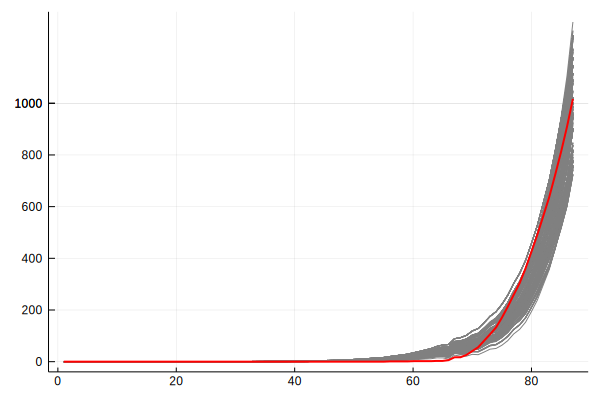

In [27]:
pl=plot(layout=1)
p2=convert(Array{Float64,1},epidemic[1:87,6])
#pl=plot!(pl,p2)
for k=1:length(ISW)
p1=convert(Array{Float64,1},Dat[ISW[k],(1*88+1):(1*88+87)])    
pl=plot!(pl,p1+p2,color="gray",legend=false)
end
pl=plot!(pl,p2,color="red",width=2)
display(pl)
